Данный ноутбук использовался для генерации данных для отчета

In [2]:
from artm_experiments import ConvexHullTopicsFilter, OptimizationTopicsFilter
import pandas as pd
import os
%pylab inline
%load_ext autoreload
%autoreload 2

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
phi = pd.read_csv('SparseSmoothDecorrelated-t100-10-i70-phi.txt', sep='\t', header=None)
phi.columns = ['topic{}'.format(idx) for idx in xrange(len(phi.columns))]
phi = phi.drop('topic100', axis=1)

theta = pd.read_csv('SparseSmoothDecorrelated-t100-10-i70-theta.txt', sep='\t', header=None)
theta.index = ['topic{}'.format(idx) for idx in xrange(len(theta.index))]
theta = theta.drop(1566, axis=1)

In [4]:
theta.head()

,0,1,2,3,4,5,6,7,8,9,...,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565
topic0,0,0,0.00241,0.000000,0.000000,0.004228,0.005988,0,0.000000,0.000000,...,0,0,0,0.007096,0.002530,0.000000,0,0,0.000000,0
topic1,0,0,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,...,0,0,0,0.000000,0.006913,0.000000,0,0,0.000000,0
topic2,0,0,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,...,0,0,0,0.000000,0.000000,0.000000,0,0,0.000000,0
topic3,0,0,0.00000,0.000000,0.007773,0.000000,0.000000,0,0.000000,0.004309,...,0,0,0,0.000000,0.000000,0.000000,0,0,0.000000,0
topic4,0,0,0.00000,0.006813,0.000000,0.044233,0.000467,0,0.001224,0.000000,...,0,0,0,0.000000,0.000000,0.014913,0,0,0.019928,0


In [5]:
phi.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic90,topic91,topic92,topic93,topic94,topic95,topic96,topic97,topic98,topic99
0,0,0,0,0,0,0,0,0,0,0,...,0.000005,0.000731,0.148827,0.009825,0.000006,0.000007,0.017058,0.000004,0.000004,0.000004
1,0,0,0,0,0,0,0,0,0,0,...,0.000003,0.062554,0.000008,0.000047,0.000260,0.000005,0.000056,0.000552,0.000004,0.082138
2,0,0,0,0,0,0,0,0,0,0,...,0.000107,0.000005,0.000005,0.000836,0.158954,0.000024,0.000004,0.000008,0.000005,0.000004
3,0,0,0,0,0,0,0,0,0,0,...,0.011240,0.003874,0.091616,0.009618,0.004040,0.000525,0.000006,0.005723,0.003289,0.000026
4,0,0,0,0,0,0,0,0,0,0,...,0.001121,0.005015,0.012055,0.041464,0.000009,0.002984,0.049733,0.005795,0.002325,0.000956


In [6]:
def list_diff(list1, list2):
    for elem1 in list1:
        if elem1 not in list2:
            print "- {}".format(elem1)
    
    for elem2 in list2:
        if elem2 not in list1:
            print "+ {}".format(elem2)
            
def display_points(phi):
    points = ConvexHullTopicsFilter.project_points(phi.as_matrix().T, dim=2)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(points[:, 0], points[:, 1], marker='o', ls='')
    for i in xrange(phi.shape[1]):
        ax.annotate(phi.columns[i], xy=points[i], textcoords='offset points')
        
    plt.show()
    
def print_top_words(phi, topic, words_number=5):
    words = phi[topic].values
    print phi.index[np.argpartition(-words, words_number)[:words_number]]
    
def save_hist(vals, bins, filename):
    bins = (bins[:-1] + bins[1:]) / 2.0
    np.savetxt(os.path.join('hists', filename), np.vstack((bins, vals)).T, delimiter=',')

In [13]:
cfilter = ConvexHullTopicsFilter(eps=1e-3, iter_num=10)
ofilter = OptimizationTopicsFilter(eps=10**(-2.5))

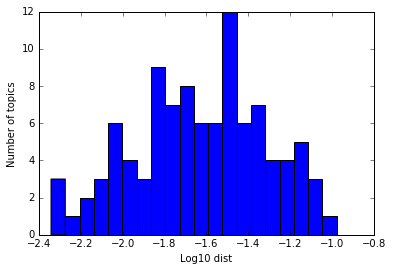

In [14]:
filtered_topics = ofilter.filter_topics(phi, list(phi.columns))
list_diff(filtered_topics, phi.columns)
vals, bins = ofilter.plot_hist()
save_hist(vals, bins, "euc_orig_data.csv")

In [9]:
import random

def generate_random_combination(phi, current_topic, current_depth=0, depth=3):
    if current_depth == depth:
        return current_topic / np.sum(current_topic)
    new_topic = random.choice(phi.columns)
    alpha = random.random()
    current_topic += alpha * phi[new_topic].as_matrix()
    return generate_random_combination(phi, current_topic, current_depth + 1, depth)

# t = (1 - alpha) * t + alpha * dirichlet[b]
def add_noise(topic, alpha=0.1, beta=0.1):
    noise = np.random.dirichlet(np.ones(len(topic)) * beta)
    new_topic = (1.0 - alpha) * topic + alpha * noise
    return new_topic

def gen_new_phi(size=10, depth=5, alpha=0.1, beta=0.1):
    random_topics = np.array([add_noise(generate_random_combination(phi, np.zeros(phi.shape[0]), depth=depth), 
                                        alpha=alpha, beta=beta)
                              for i in xrange(size)]).T

    phi_new = pd.concat((phi, pd.DataFrame(random_topics, index=phi.index)), axis=1)
    phi_new.columns = ['topic{}'.format(idx) for idx in xrange(len(phi_new.columns))]
    return phi_new

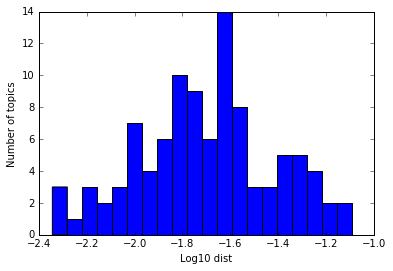

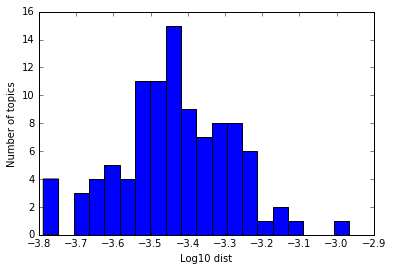

Depth 10 Alpha 0.0 Beta 1e-05 Filtered 100


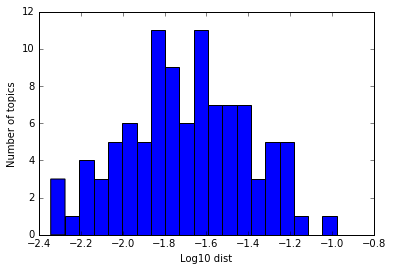

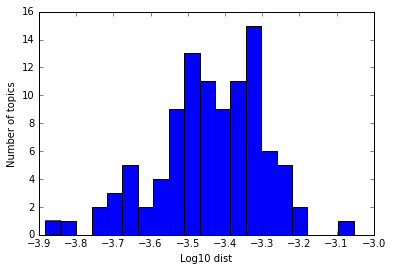

Depth 10 Alpha 0.0 Beta 0.0001 Filtered 100


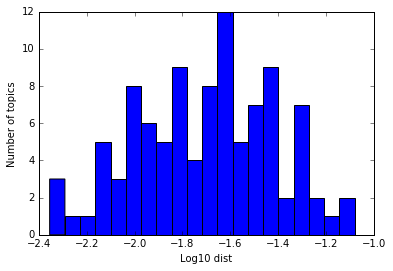

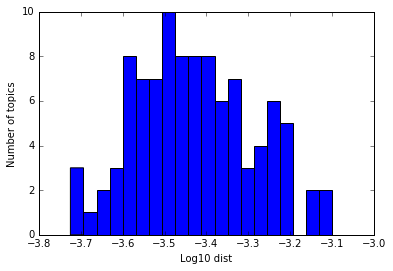

Depth 10 Alpha 0.0 Beta 0.001 Filtered 100


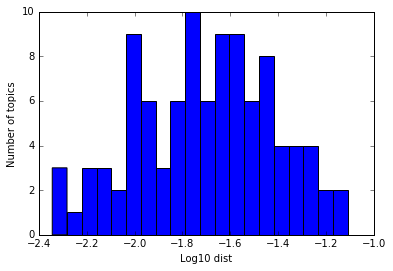

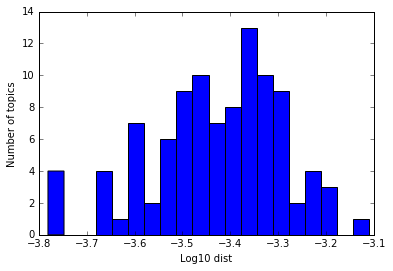

Depth 10 Alpha 0.0 Beta 0.01 Filtered 100


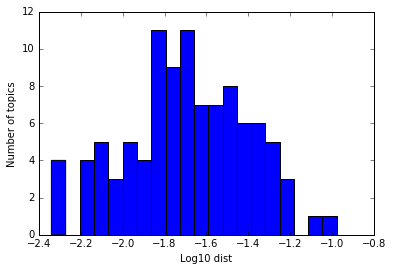

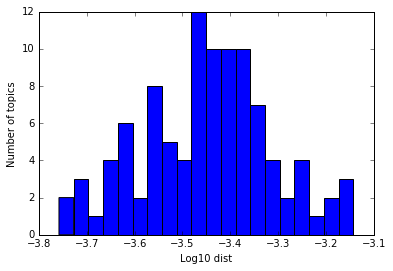

Depth 10 Alpha 0.0 Beta 0.1 Filtered 100


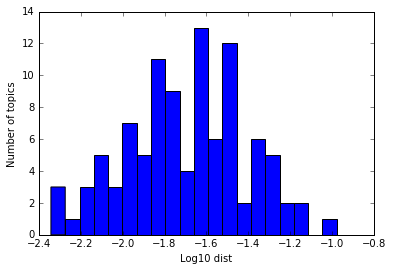

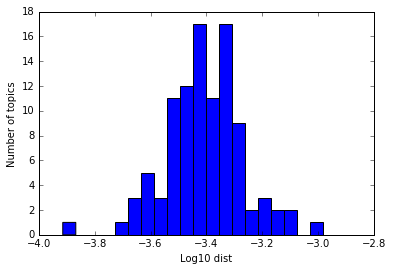

Depth 10 Alpha 0.0 Beta 1.0 Filtered 100


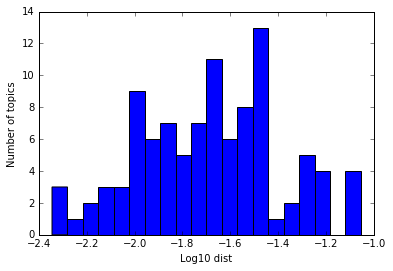

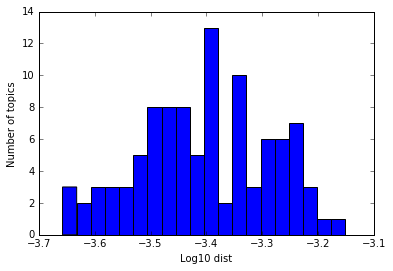

Depth 10 Alpha 0.0 Beta 10.0 Filtered 100


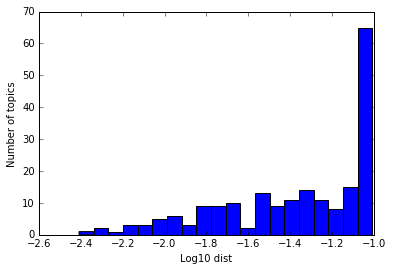

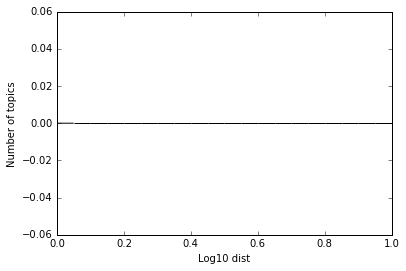

Depth 10 Alpha 0.3 Beta 1e-05 Filtered 200


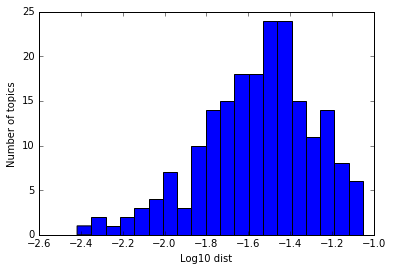

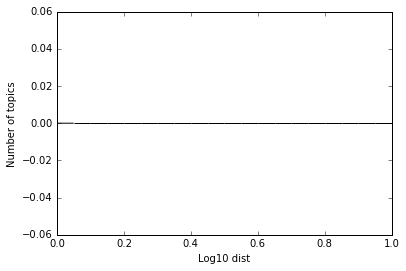

Depth 10 Alpha 0.3 Beta 0.0001 Filtered 200


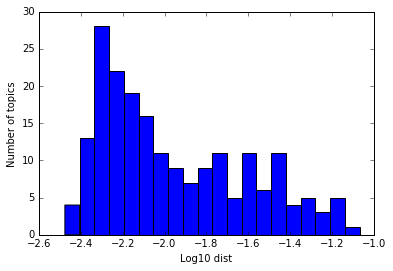

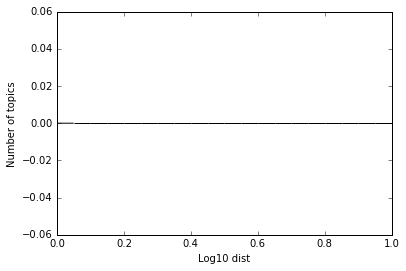

Depth 10 Alpha 0.3 Beta 0.001 Filtered 200


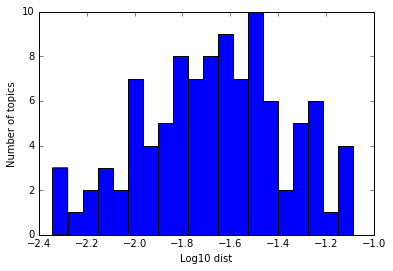

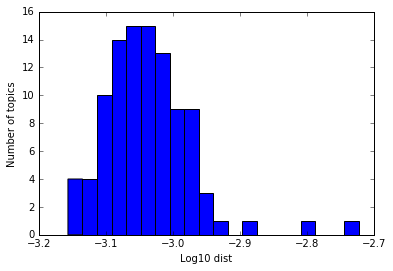

Depth 10 Alpha 0.3 Beta 0.01 Filtered 100


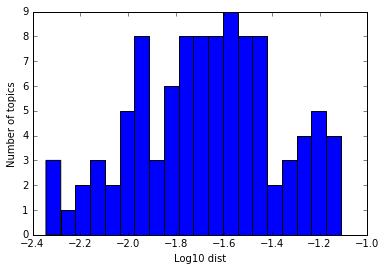

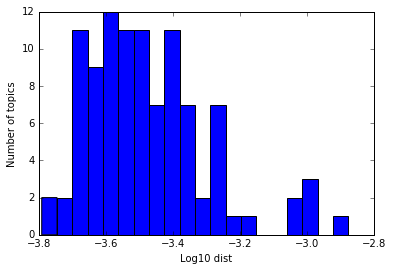

Depth 10 Alpha 0.3 Beta 0.1 Filtered 100


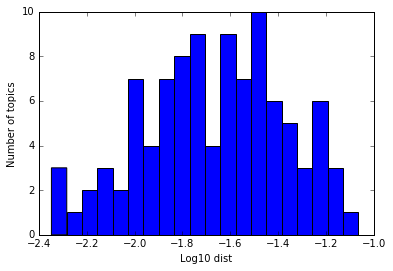

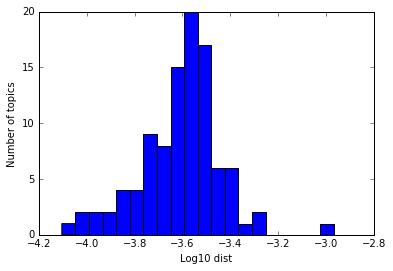

Depth 10 Alpha 0.3 Beta 1.0 Filtered 100


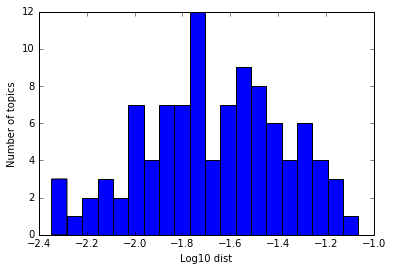

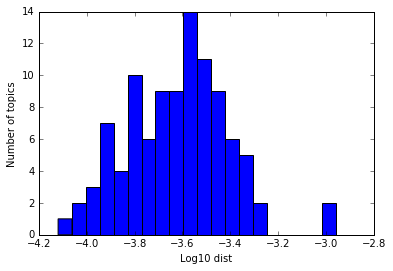

Depth 10 Alpha 0.3 Beta 10.0 Filtered 100


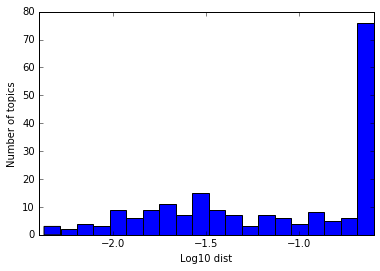

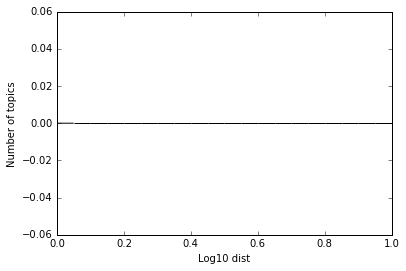

Depth 10 Alpha 0.5 Beta 1e-05 Filtered 200


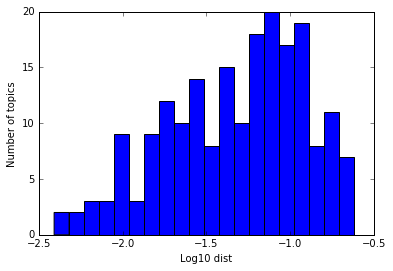

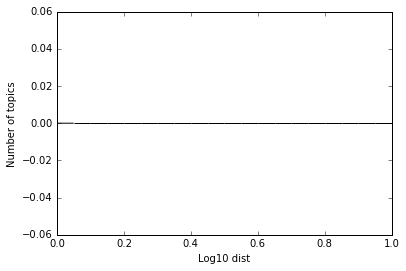

Depth 10 Alpha 0.5 Beta 0.0001 Filtered 200


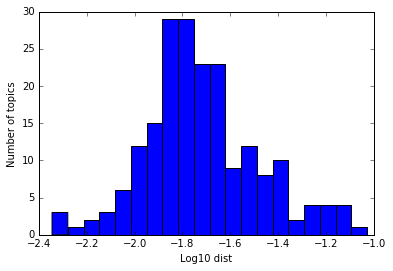

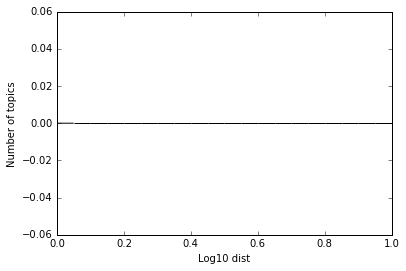

Depth 10 Alpha 0.5 Beta 0.001 Filtered 200


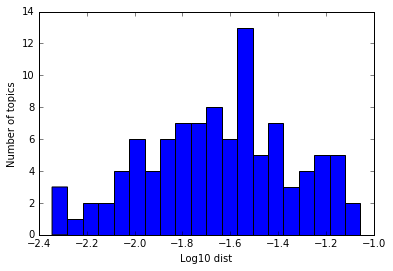

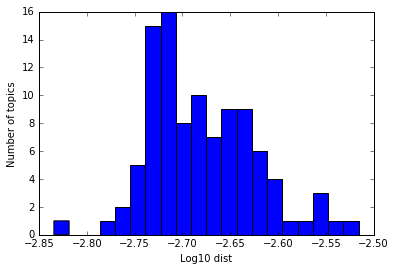

Depth 10 Alpha 0.5 Beta 0.01 Filtered 100


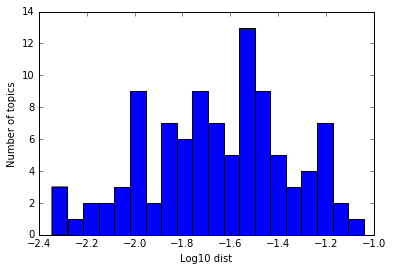

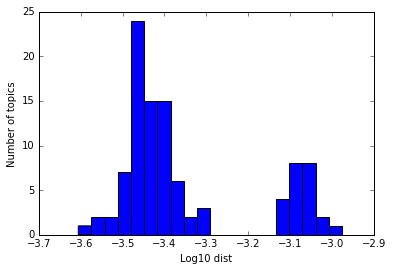

Depth 10 Alpha 0.5 Beta 0.1 Filtered 100


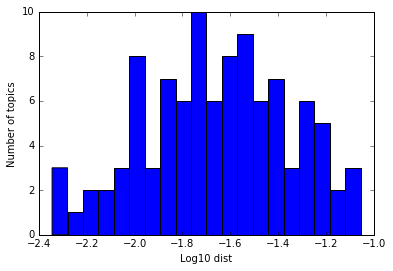

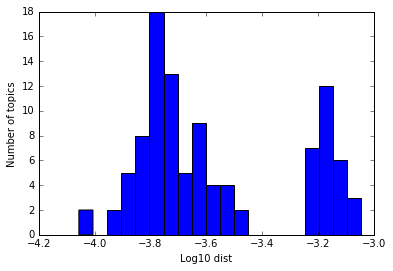

Depth 10 Alpha 0.5 Beta 1.0 Filtered 100


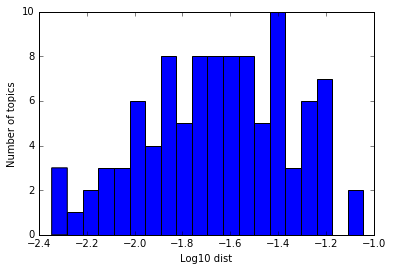

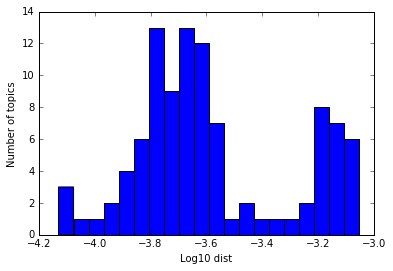

Depth 10 Alpha 0.5 Beta 10.0 Filtered 100


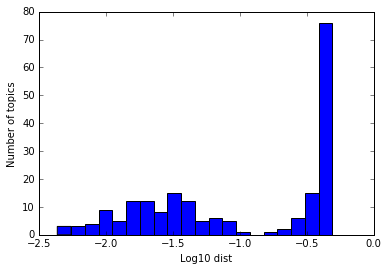

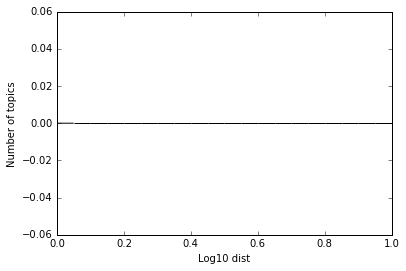

Depth 10 Alpha 0.7 Beta 1e-05 Filtered 200


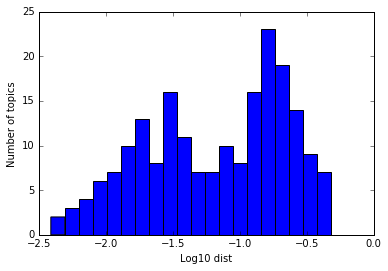

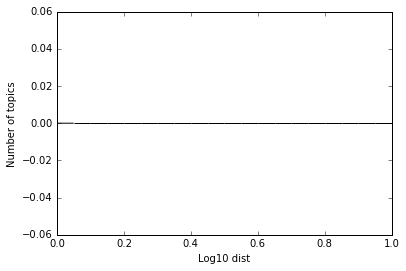

Depth 10 Alpha 0.7 Beta 0.0001 Filtered 200


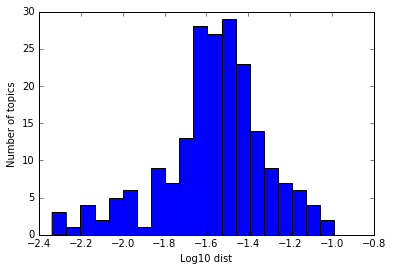

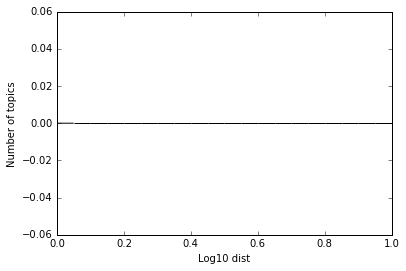

Depth 10 Alpha 0.7 Beta 0.001 Filtered 200


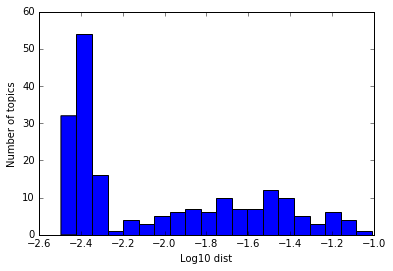

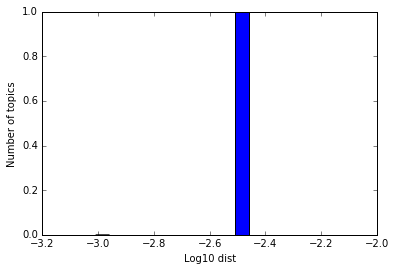

Depth 10 Alpha 0.7 Beta 0.01 Filtered 199


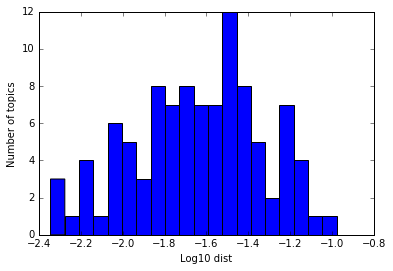

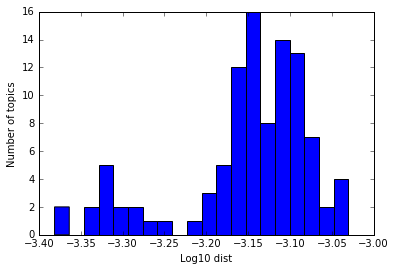

Depth 10 Alpha 0.7 Beta 0.1 Filtered 100


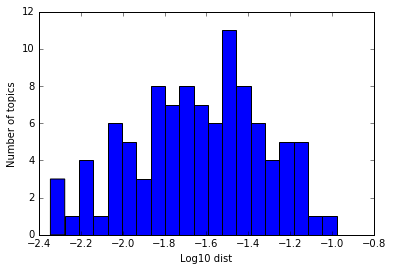

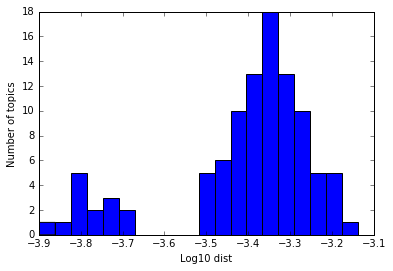

Depth 10 Alpha 0.7 Beta 1.0 Filtered 100


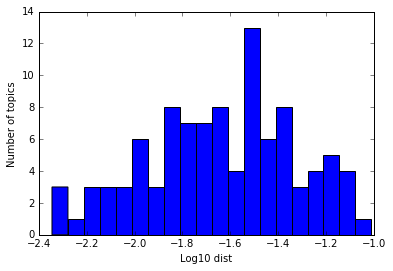

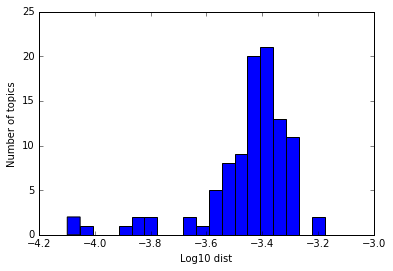

Depth 10 Alpha 0.7 Beta 10.0 Filtered 100


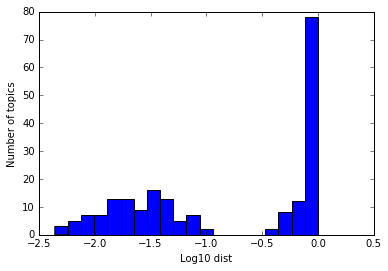

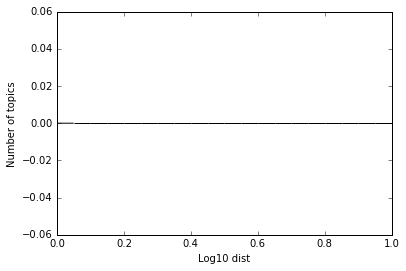

Depth 10 Alpha 1.0 Beta 1e-05 Filtered 200


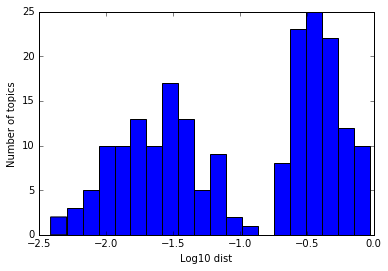

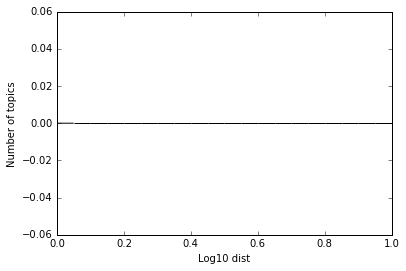

Depth 10 Alpha 1.0 Beta 0.0001 Filtered 200


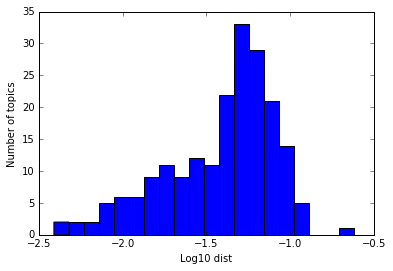

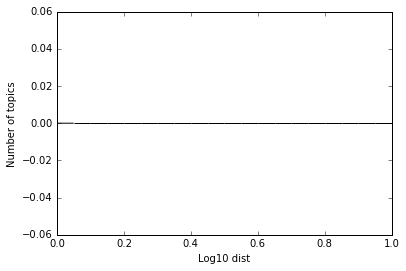

Depth 10 Alpha 1.0 Beta 0.001 Filtered 200


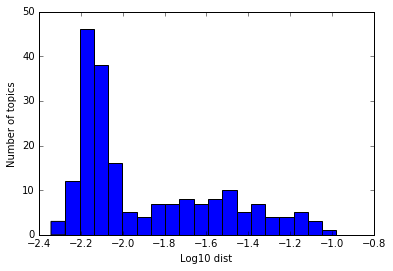

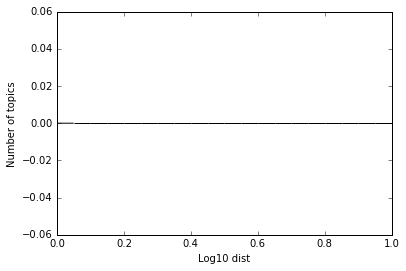

Depth 10 Alpha 1.0 Beta 0.01 Filtered 200


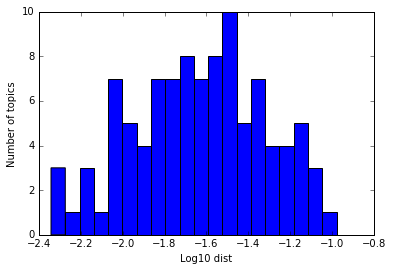

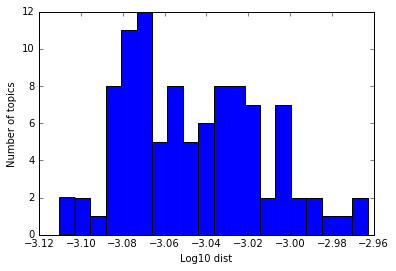

Depth 10 Alpha 1.0 Beta 0.1 Filtered 100


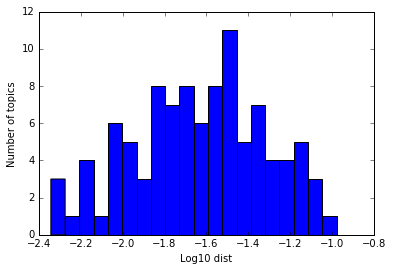

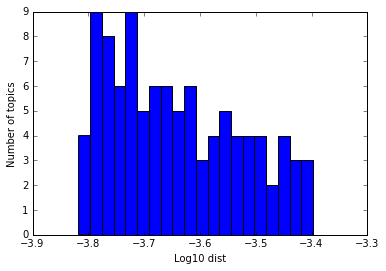

Depth 10 Alpha 1.0 Beta 1.0 Filtered 100


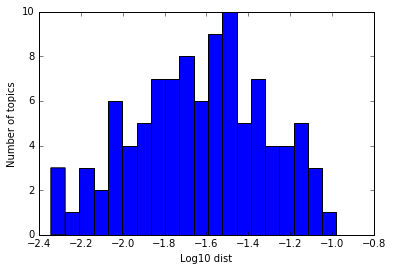

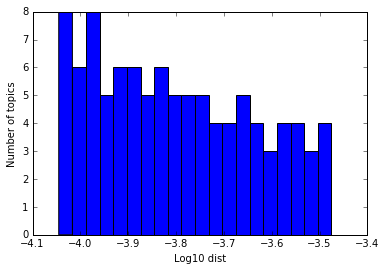

Depth 10 Alpha 1.0 Beta 10.0 Filtered 100


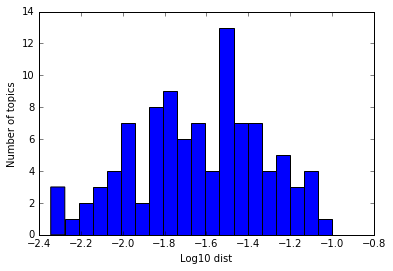

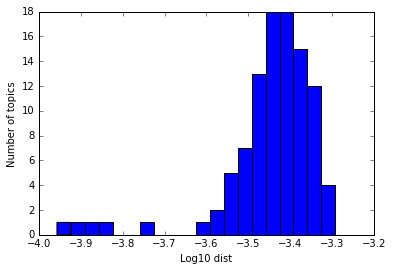

Depth 100 Alpha 0.0 Beta 1e-05 Filtered 100


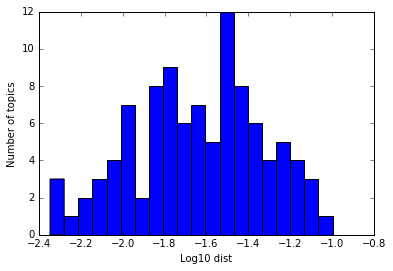

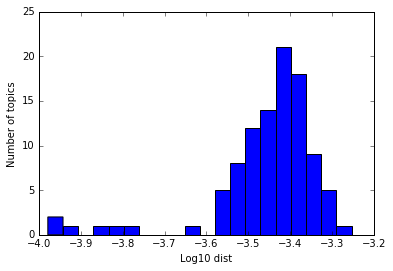

Depth 100 Alpha 0.0 Beta 0.0001 Filtered 100


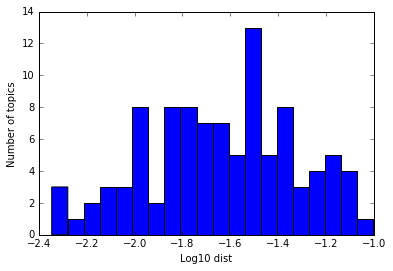

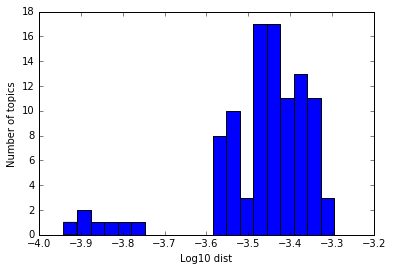

Depth 100 Alpha 0.0 Beta 0.001 Filtered 100


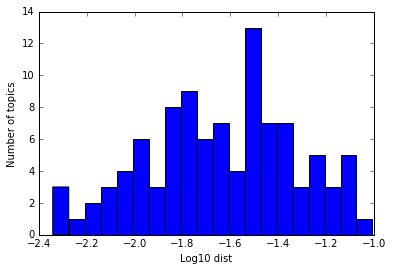

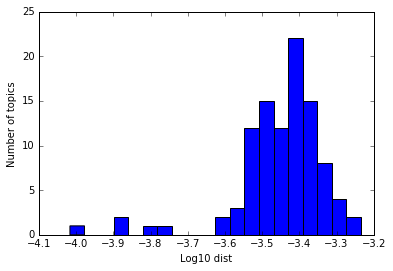

Depth 100 Alpha 0.0 Beta 0.01 Filtered 100


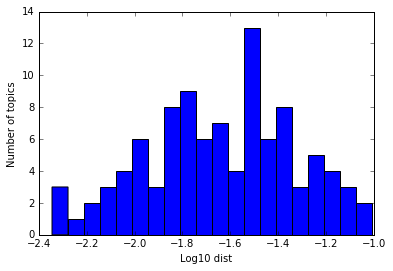

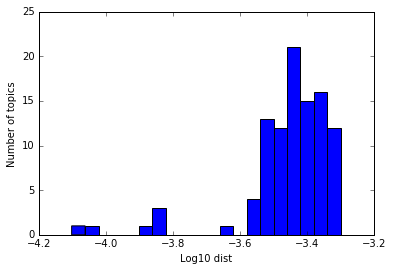

Depth 100 Alpha 0.0 Beta 0.1 Filtered 100


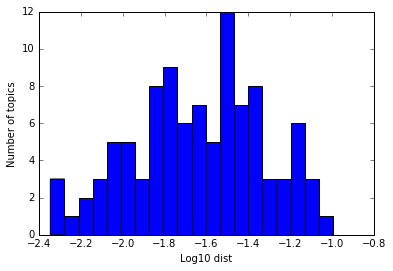

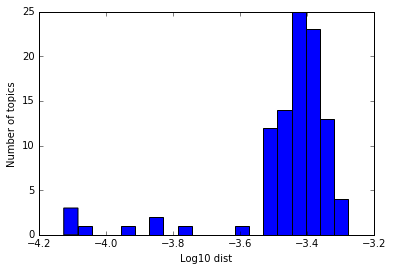

Depth 100 Alpha 0.0 Beta 1.0 Filtered 100


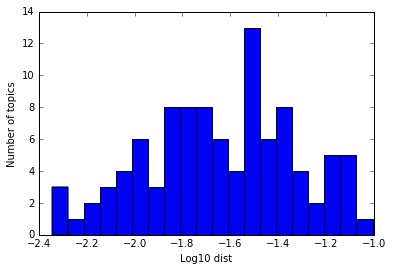

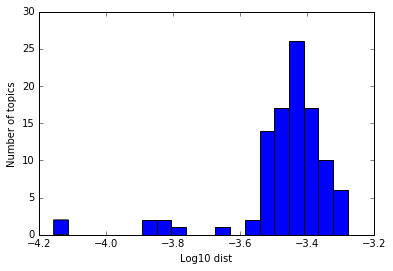

Depth 100 Alpha 0.0 Beta 10.0 Filtered 100


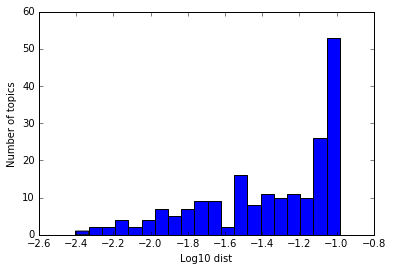

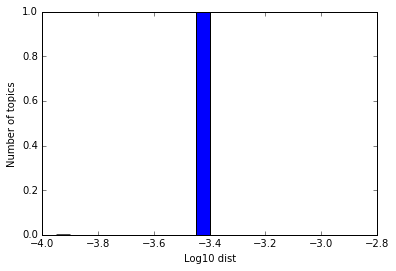

Depth 100 Alpha 0.3 Beta 1e-05 Filtered 199


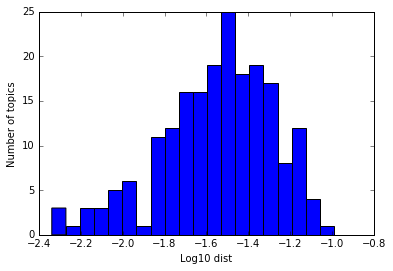

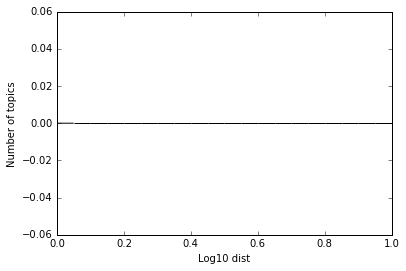

Depth 100 Alpha 0.3 Beta 0.0001 Filtered 200


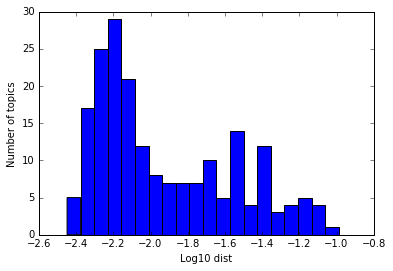

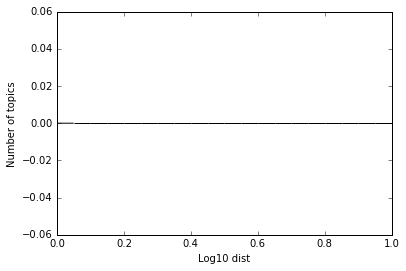

Depth 100 Alpha 0.3 Beta 0.001 Filtered 200


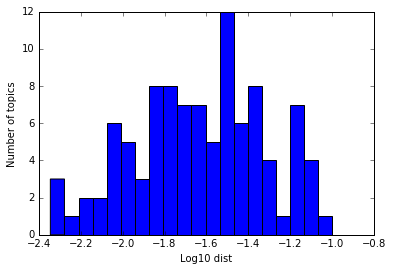

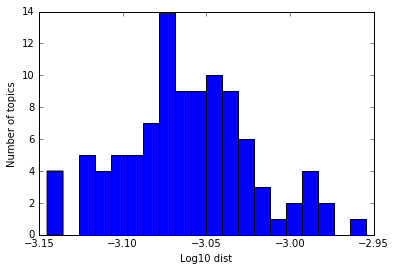

Depth 100 Alpha 0.3 Beta 0.01 Filtered 100


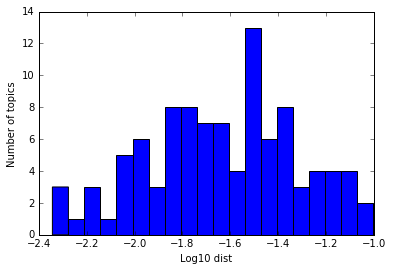

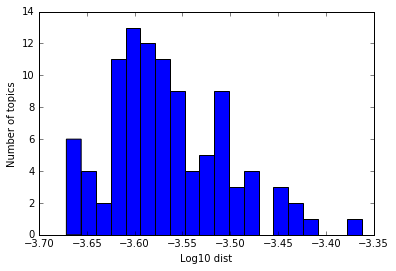

Depth 100 Alpha 0.3 Beta 0.1 Filtered 100


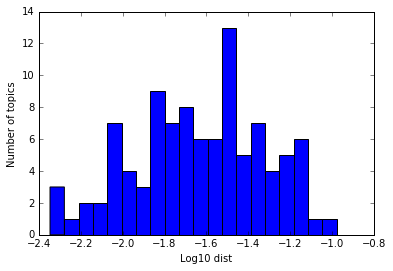

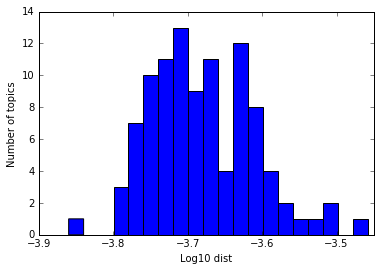

Depth 100 Alpha 0.3 Beta 1.0 Filtered 100


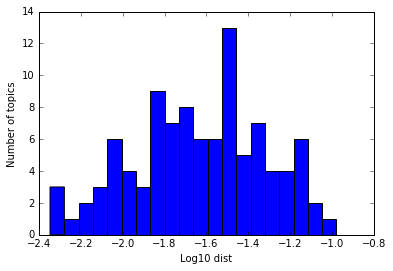

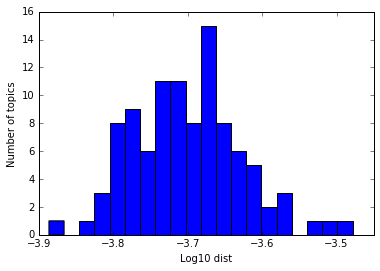

Depth 100 Alpha 0.3 Beta 10.0 Filtered 100


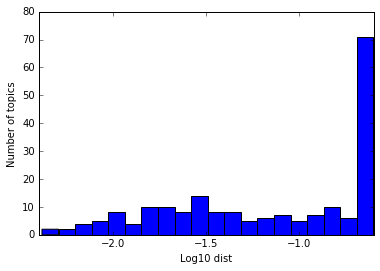

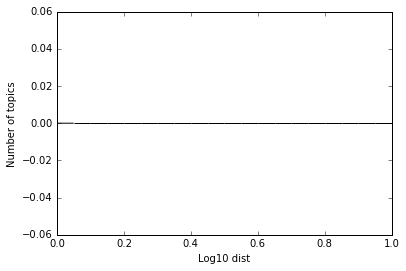

Depth 100 Alpha 0.5 Beta 1e-05 Filtered 200


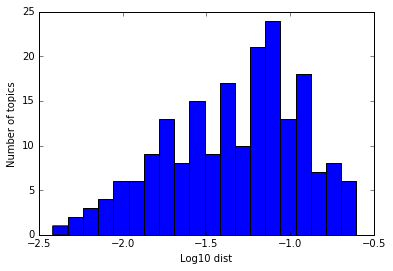

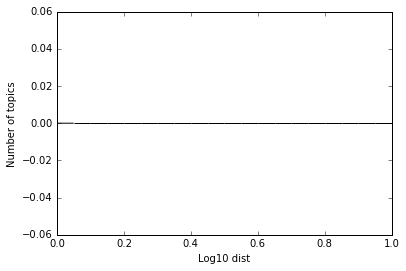

Depth 100 Alpha 0.5 Beta 0.0001 Filtered 200


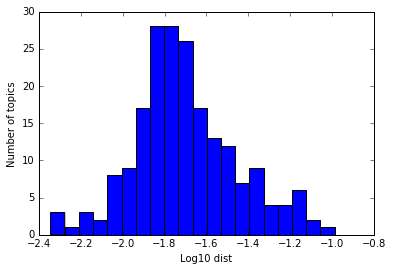

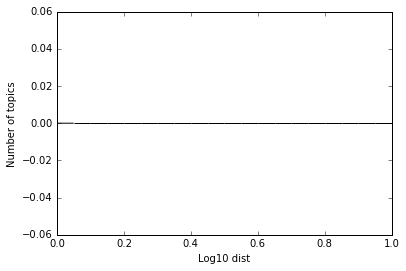

Depth 100 Alpha 0.5 Beta 0.001 Filtered 200


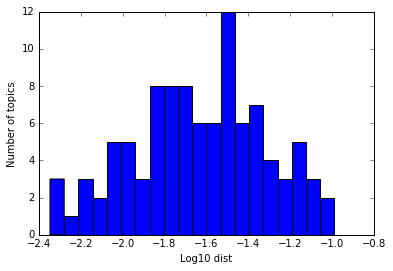

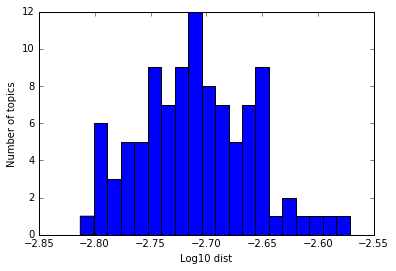

Depth 100 Alpha 0.5 Beta 0.01 Filtered 100


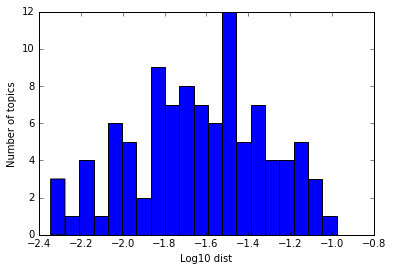

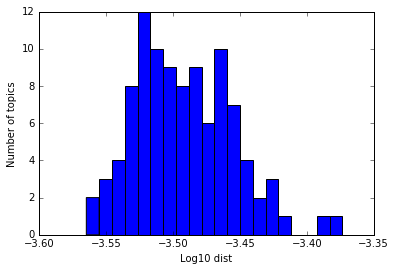

Depth 100 Alpha 0.5 Beta 0.1 Filtered 100


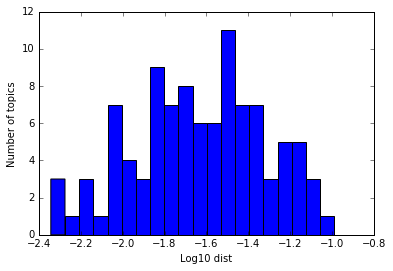

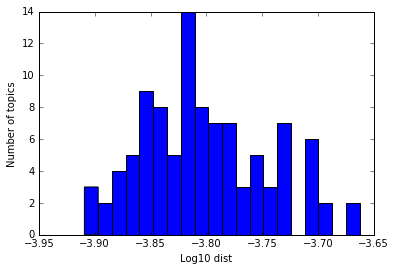

Depth 100 Alpha 0.5 Beta 1.0 Filtered 100


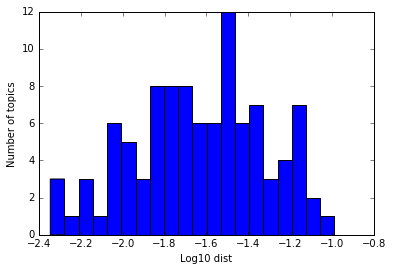

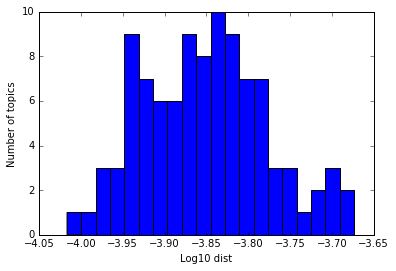

Depth 100 Alpha 0.5 Beta 10.0 Filtered 100


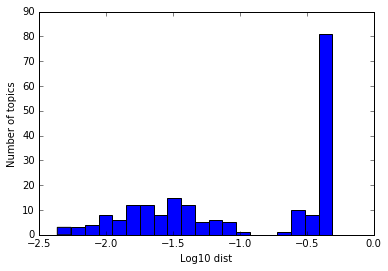

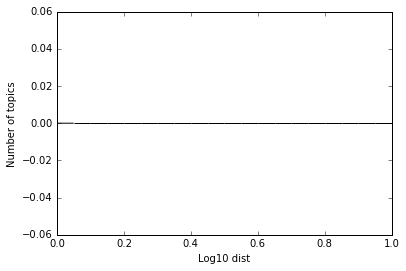

Depth 100 Alpha 0.7 Beta 1e-05 Filtered 200


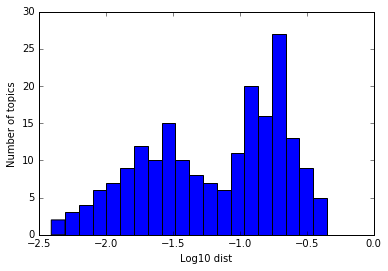

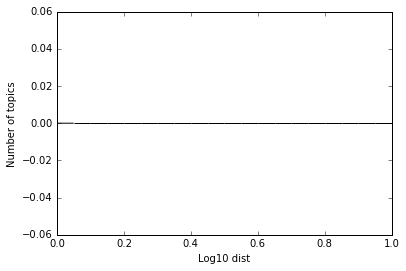

Depth 100 Alpha 0.7 Beta 0.0001 Filtered 200


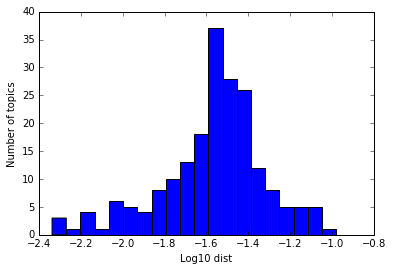

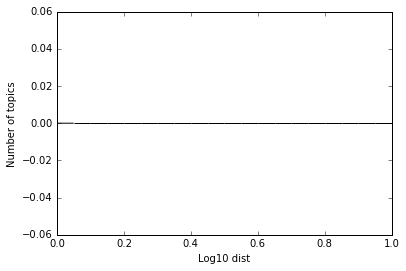

Depth 100 Alpha 0.7 Beta 0.001 Filtered 200


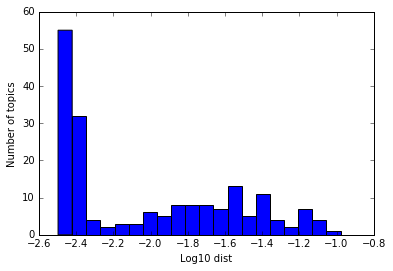

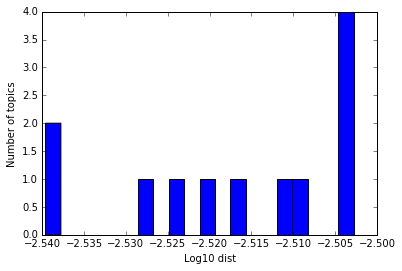

Depth 100 Alpha 0.7 Beta 0.01 Filtered 188


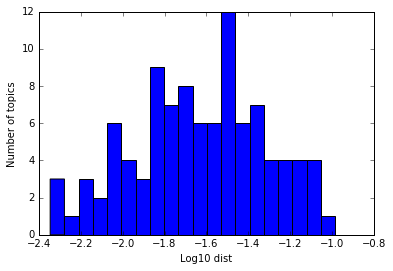

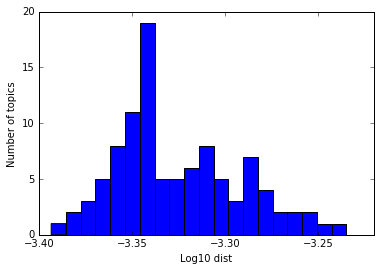

Depth 100 Alpha 0.7 Beta 0.1 Filtered 100


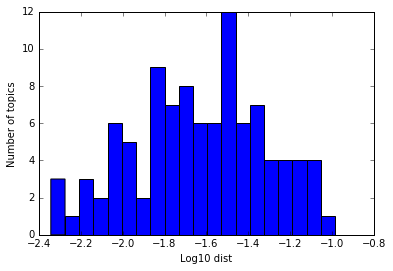

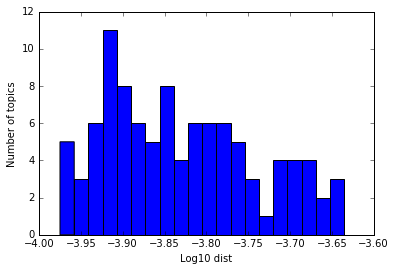

Depth 100 Alpha 0.7 Beta 1.0 Filtered 100


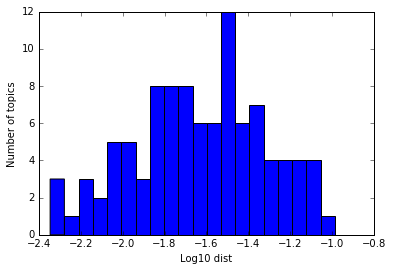

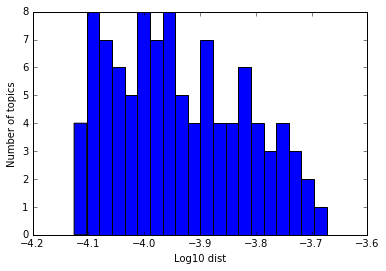

Depth 100 Alpha 0.7 Beta 10.0 Filtered 100


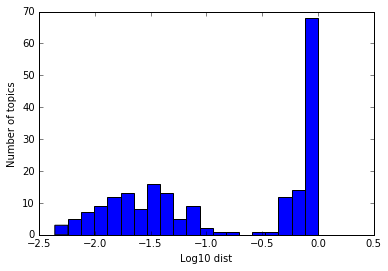

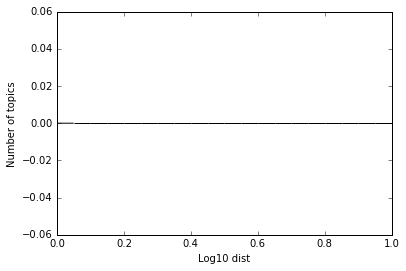

Depth 100 Alpha 1.0 Beta 1e-05 Filtered 200


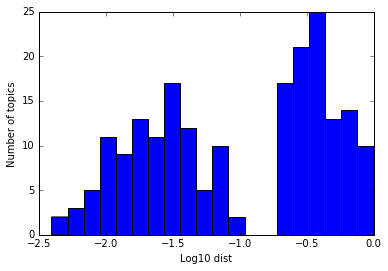

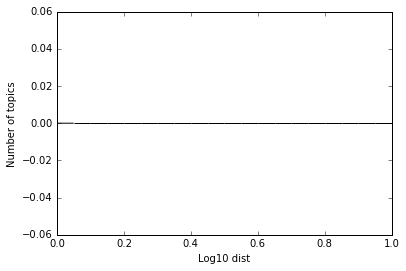

Depth 100 Alpha 1.0 Beta 0.0001 Filtered 200


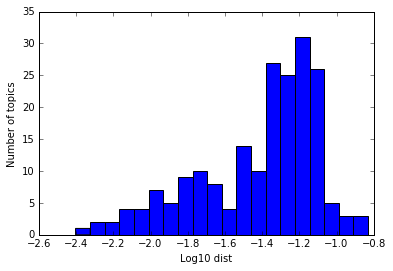

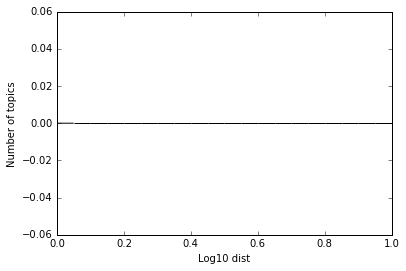

Depth 100 Alpha 1.0 Beta 0.001 Filtered 200


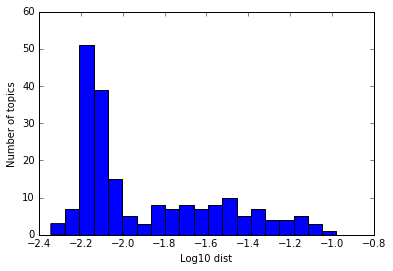

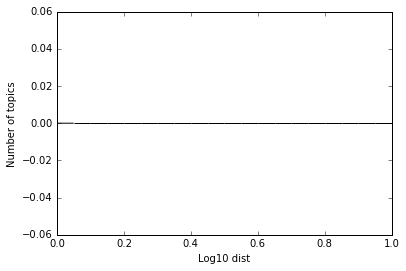

Depth 100 Alpha 1.0 Beta 0.01 Filtered 200


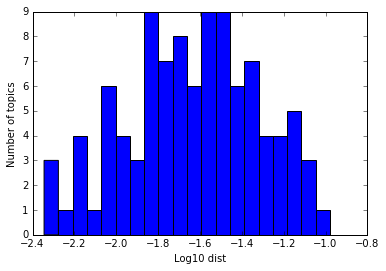

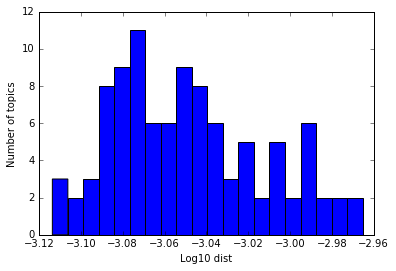

Depth 100 Alpha 1.0 Beta 0.1 Filtered 100


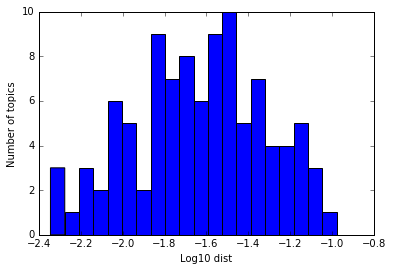

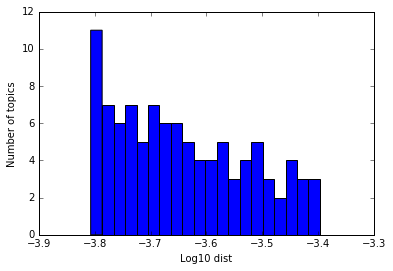

Depth 100 Alpha 1.0 Beta 1.0 Filtered 100


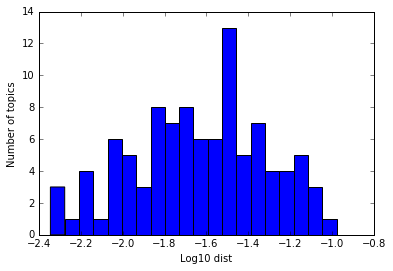

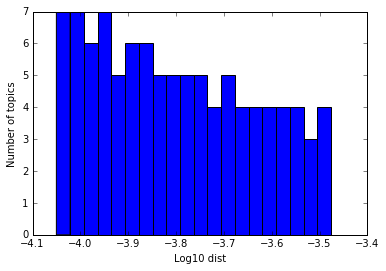

Depth 100 Alpha 1.0 Beta 10.0 Filtered 100


In [15]:
import csv 

prefix_metric = 'euc' + '_n'

def run_filter(depth, alpha, alphai, beta, betai):
    phi_new = gen_new_phi(size=100, depth=depth, alpha=alpha, beta=beta)
    filtered_topics = ofilter.filter_topics(phi_new, phi_new.columns)
    other_topics = [topic for topic in phi_new.columns if topic not in filtered_topics]

    filtered_vals = [ofilter.res_vals[topic] for topic in filtered_topics]
    other_vals = [ofilter.res_vals[topic] for topic in other_topics]
    if len(other_vals) == 0:
        other_vals.append(0.0)

    fvals, fbins = ofilter.plot_hist(filtered_topics)
    save_hist(fvals, fbins, "fil_{}_art_depth{}alp{}bet{}.csv".format(prefix_metric, 
                                                                       depth, alphai, betai))

    ovals, obins = ofilter.plot_hist(other_topics)
    save_hist(ovals, obins, "oth_{}_art_depth{}alp{}bet{}.csv".format(prefix_metric, 
                                                                       depth, alphai, betai))
    
    return filtered_vals, other_vals


with open('{}_data.csv'.format(prefix_metric), 'a') as data_file:
    data_writer = csv.writer(data_file)
    data_writer.writerow(['depth', 'alpha', 'beta', 'base_len',
                          'mean_val_filtered', 'mean_val_other', 
                          'std_val_filtered', 'std_val_other',
                          'max_val_filtered', 'min_val_other'])
    for depth in [10, 100]:
        for alphai, alpha in enumerate([0.0, 0.3, 0.5, 0.7, 1.0]):
            for betai, beta in enumerate([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]):
                filtered_vals, other_vals = run_filter(depth, alpha, alphai, beta, betai)
                print "Depth {} Alpha {} Beta {} Filtered {}".format(depth, alpha, beta, len(filtered_vals))
                data_writer.writerow([depth, alpha, beta, len(filtered_vals),
                                      np.mean(filtered_vals), np.mean(other_vals), 
                                      np.std(filtered_vals), np.std(other_vals),
                                      np.max(filtered_vals), np.min(other_vals)])

[autoreload of optimize_methods failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "optimize_methods.py", line 62
    
    ^
IndentationError: expected an indented block
]


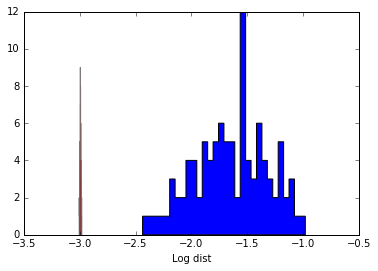

In [86]:
vals = np.array(vals)
is_added_topic = np.array([int(topic[5:]) >= 100 for topic in sh_topics])
data_original = vals[np.logical_not(is_added_topic)]
data_added = vals[is_added_topic]
plt.hist(np.log10(data_original), bins=30, histtype='stepfilled')
plt.hist(np.log10(data_added), bins=30, histtype='stepfilled', color='r', alpha=0.5)
plt.xlabel('Log dist')
plt.show()